# Processing

### Initialization

[ 134.  141.  128. ...,   81.   57.   74.]


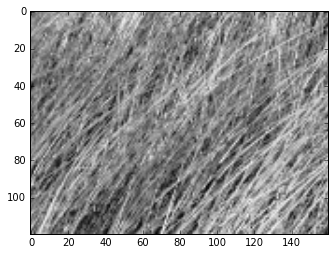

In [14]:
import numpy as np
sample = np.load('data\samplevideo.npy')
print(sample[0,:])

import matplotlib.pyplot as mp
% matplotlib inline
image = mp.imshow(sample[0,:].reshape((120,160)),cmap='Greys_r')

In [15]:
# Initialize the latent variable using PCA:
from sklearn.decomposition import PCA

N = sample.shape[0] # count of samples
D = sample.shape[1] # dimensionality of observed space
Q = 20 # dimensionality of observed space

X = np.zeros((N,Q)) # Initialize the latent variable

sample = (sample - np.mean(sample, 0)) / np.std(sample, 0) # normalization
pca = PCA(n_components=Q) 
X = pca.fit_transform(sample) # performing PCA
print(X[0,:])

[ 23.73651164 -20.94734111  23.281226    22.6802055   -7.50919708
  34.30870091 -12.46201579   8.07417771 -12.95784813   9.80002935
  -6.88500422   0.63095893 -13.29798142  19.54781085  -4.42927045
   2.70507576  -5.53067023   4.97089492  -7.19820107  13.64289273]


### Optimization

In [58]:
from sympy import KroneckerDelta

def K_x(w,x1,x2):
    
    #k1 = ?
    #k2 = ?
    #k3 = ?
    #k4 = ?
    #k5 = ?
    #k6 = ?
    
    return w[0]*k1(x1,x2)+w[1]*k2(x1,x2)+w[2]*k3(x1,x2)+w[3]*k4(x1,x2)+w[4]*k5(x1,x2)+w[5]*k6(x1,x2)+w[6]*KroneckerDelta(x1,x2)

In [59]:
def K_y1(theta,x1,x2):
    
    return theta[0]*np.exp(-0.5*theta[1]*np.matmul((x1 - x2),np.transpose(x1 - x2))) + theta[2]*KroneckerDelta(x1,x2)

In [61]:
def K_y(theta,x1,x2):
    
    return theta[0]*np.exp(-0.5*theta[1]*((x1 - x2)**2).sum(axis=-1)) #+ theta[2]*KroneckerDelta(x1,x2)

In [28]:
def weight_likelihood(Q,N,Kx,X,W):
    alpha = 1
    Kx_inv = np.linalg.inv(Kx)
    part1 = 0.5*Q*np.log(np.linalg.det(Kx_inv))
    part2 = 0.5*np.trace(Kx_inv*np.matmul(X[1:N],np.transpose(X)[1:N]))
    part3 = alpha*np.linalg.norm(W,2)
    print(part1)
    return part1 + part2 + part3

In [20]:
# [params, options, flog] = scg('mk_likelihood', params, options, 'mk_gradient', Y, segments, kern)

# check weight_likelihood and mk_likelihood with Kx and Ky and rewrite if necessary

#write mk_weightsConstrain function
#write mk_priorIO function
#finish function weight_gradient

# search for kern gradients

# find scg function for Python

In [22]:
X

array([[ 23.73651164, -20.94734111,  23.281226  , ...,   4.97089492,
         -7.19820107,  13.64289273],
       [ 27.32166362, -26.17117093,  30.51346662, ...,   5.31042802,
         -3.90021055,   6.96400856],
       [ 26.23488005, -28.1899192 ,  29.81997129, ...,   6.88485175,
         -3.33337264,   2.68275034],
       ..., 
       [ -7.47424951, -22.09849862,  16.11440062, ...,  11.91163886,
          3.49564572,  13.00946041],
       [  4.99655619, -19.65781084,  12.97498904, ...,   4.28578476,
          8.66982982,   7.2620896 ],
       [ 11.75766947,  -9.51504745,  10.57365739, ...,   5.78658013,
         13.88101326,   3.16272507]])

[[ 1.          0.97398076  0.94107683 ...,  0.81815586  0.85101093
   0.82551641]
 [ 0.97398076  1.          0.98549815 ...,  0.76271269  0.79750592
   0.76817639]
 [ 0.94107683  0.98549815  1.         ...,  0.73676084  0.77379312
   0.73704889]
 ..., 
 [ 0.81815586  0.76271269  0.73676084 ...,  1.          0.94740378
   0.88551751]
 [ 0.85101093  0.79750592  0.77379312 ...,  0.94740378  1.          0.97214479]
 [ 0.82551641  0.76817639  0.73704889 ...,  0.88551751  0.97214479  1.        ]]


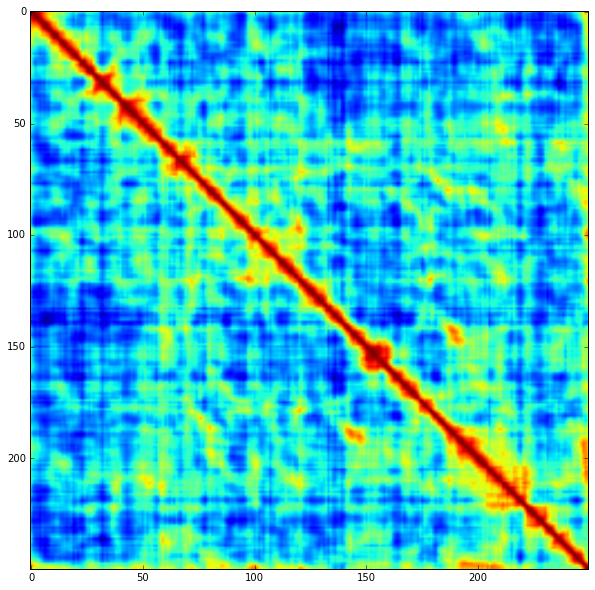

In [69]:
# K_y test:
theta = [1, 0.0001, 1]
Ky = K_y(theta,X.reshape(1,-1,Q),X.reshape(-1,1,Q))
#print(Ky.shape[0], Ky.shape[1])

#Ky = np.zeros((N,N))
#for i in range(N):
#    for j in range(N):
#        Ky[i,j] = K_y(theta,X[i,:],X[j,:])
print(Ky)

# visualization of kernel matrix


fig = mp.figure(figsize=(10,10)) # scale of the plot
image = mp.imshow(Ky)
#mp.show()

In [30]:
# weight_likelihood test:
a = [[1,0,0],[0,1,0],[0,0,1]]
x = [9,8,7,6]
c = [1,2,3,4,5,6]

print(weight_likelihood(20,4,a,x,c))
print(np.linalg.norm(c,2))

0.0
233.039392014
9.53939201417


In [14]:
KroneckerDelta(3,3)

1

In [76]:
def mk_likelihood(D,Q,N,Kx,Ky,X,Y,theta,lamb):
    C = 0
    Kx_inv = np.linalg.inv(Kx)
    Ky_inv = np.linalg.inv(Ky)
    part1 = 0.5*D*np.log(np.linalg.det(Ky))
    part2 = 0.5*np.matmul(np.transpose(Y),np.matmul(Ky_inv,Y))
    part3 = 0.5*Q*np.log(np.linalg.det(Kx_inv))
    part4 = 0.5*np.trace(Kx_inv*np.matmul(X[1:N],np.transpose(X)[1:N]))
    part5 = np.sum(theta)
    part6 = np.sum(lamb)
    return part1 + part2 + part3 + part4 + part5 + part6 + C

In [ ]:
def weight_gradient(Q,N,Kx,X,W):
    
    #params = mk_weightsConstrain(params)
    
    #[Xin, Xout] = mk_priorIO(X, segments)
    
    Kx_inv = np.linalg.inv(Kx)
    #dL_dKx = -Q/2*invKx + 0.5*invKx*(Xout*Xout')*invKx
    
    #g = zeros(length(kern.comp),1)
    
    #for i = 1:length(kern.comp)
    #    g(i) = sum(sum(dL_dKx .* Kx{i}))
    
    norm2 = 1/np.linalg.norm(W,2)
    
    #for i = 1:length(kern.comp)
    #    g(i) = g(i) + norm2 * params(i)
    
    g = g/np.linalg.norm(g2)
    
    return -np.transpose(g)

In [21]:
def mk_gradient(Q,N,D,Kx,Ky,X,Y,theta,lamb):
    
    Kx_inv = np.linalg.inv(Kx)    
    Ky_inv = np.linalg.inv(Ky)
    
    dL_dX = dL_dKy * dKy_dX + dL_dKx * dKx_dX + dL_dx2 * dx2_dX
    
    dL_dKy = 0.5*D*np.transpose(Ky_inv)-0.5*np.transpose(np.matmul((Ky_inv*np.matmul(Y,np.transpose(Y))),Ky_inv))
    dL_dKx = 0.5*Q*np.transpose(Kx_inv)-0.5*np.transpose(np.matmul((Kx_inv*np.matmul(X[1:N],np.transpose(X[1:N]))),Kx_inv))
    dL_dx2 = 0.5*(np.matmul(Kx_inv,X[1:N])+np.matmul(np.transpose(Kx_inv),X[1:N]))
    
    #dKy_dX = ?
    #dKx_dX = ?
    #dx2_dX = ?
    
    dL_dTht1 = 0.5*D*np.trace(Ky_inv*dKy_dTht)
    dL_dTht2 = 0.5*np.transpose(np.matmul((Ky_inv*np.matmul(Y,np.transpose(Y))),Ky_inv))*dKy_dTht
    dL_dTht3 = 1/theta
    #dKy_dTht = ?
    
    dL_dLam1 = 0.5*Q*np.trace(Kx_inv*dKx_dLam)
    dL_dLam2 = 0.5*np.transpose(np.matmul((Kx_inv*np.matmul(X[1:N],np.transpose(X[1:N]))),Kx_inv))*dKx_dTLam
    dL_dLam3 = 1/lamb
    #dKx_dLam = ?
    
    dL_dTht = dL_dTht1 - dL_dTht2 + dL_dTht3
    
    dL_dLam = dL_dLam1 - dL_dLam2 + dL_dLam3
    
    return [dL_dX, dL_dTheta, dL_dLam]

<font color='red'>**Necessary kerns:**</font> 'lin','rbf','poly','ratquad','mlp','matern32'. Let's try to use GPy (Gaussian Process framework in python, from the Sheffield machine learning group). We'll get the following:

'lin' **GPy.kern.src.linear** class Linear(input_dim, variances=None, ARD=False, active_dims=None, name='linear')

'rbf' **GPy.kern.src.rbf** class RBF(input_dim, variance=1.0, lengthscale=None, ARD=False, active_dims=None, name='rbf', useGPU=False, inv_l=False)

'poly' **GPy.kern.src.poly** class Poly(input_dim, variance=1.0, scale=1.0, bias=1.0, order=3.0, active_dims=None, name='poly')

'ratquad' **GPy.kern.src.stationary** class RatQuad(input_dim, variance=1.0, lengthscale=None, power=2.0, ARD=False, active_dims=None, name='RatQuad')

'mlp' **GPy.kern.src.mlp** class MLP(input_dim, variance=1.0, weight_variance=1.0, bias_variance=1.0, ARD=False, active_dims=None, name='mlp')

'matern32' **GPy.kern.src.stationary** class Matern32(input_dim, variance=1.0, lengthscale=None, ARD=False, active_dims=None, name='Mat32')

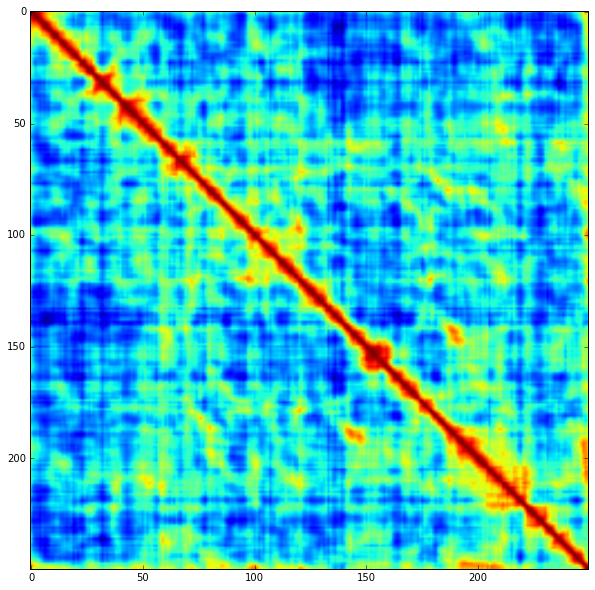

In [70]:
import GPy

k = GPy.kern.RBF(Q,1,100)
l=k.K(X,X)
fig = mp.figure(figsize=(10,10)) # scale of the plot
mp.imshow(l)